***HOTEL BOOKING ANALYSIS : PREDICTING CANCELLATION***


In [2]:
#essential
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier

# Models
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import accuracy_score 
from sklearn.model_selection import cross_val_score
#from sklearn.metrics import classification_report
#from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline,Pipeline

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [3]:
#load data
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/IU Sem1 2023/Data Analysis/Group 13_DA Project/hotel_bookings.csv'
df = pd.read_csv(path)

In [5]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

##EDA

**We just explore some important features**::



Text(0, 0.5, 'Count')

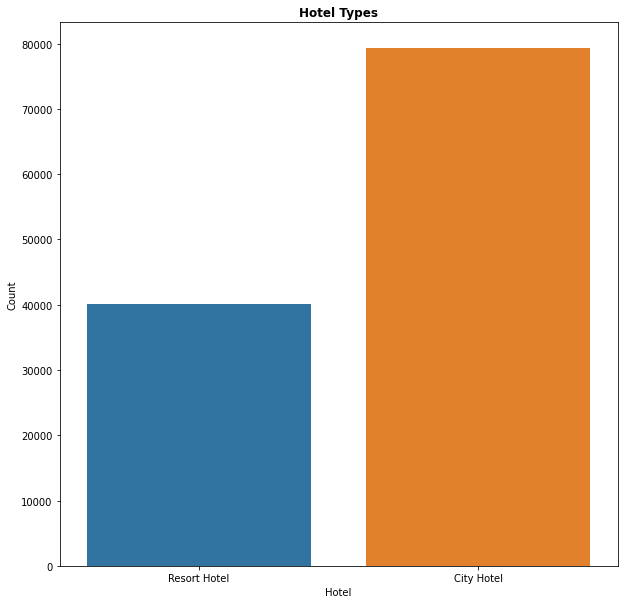

In [7]:
#hotel features
plt.figure(figsize=(10,10))
sns.countplot( data = df, x='hotel')
plt.title('Hotel Types', weight='bold')
plt.xlabel('Hotel', fontsize=10)
plt.ylabel('Count', fontsize=10)


as we can see, 34% customer booked Resort Hotel and
66% booked City Hotel

Text(0, 0.5, 'Canceled or Not Canceled')

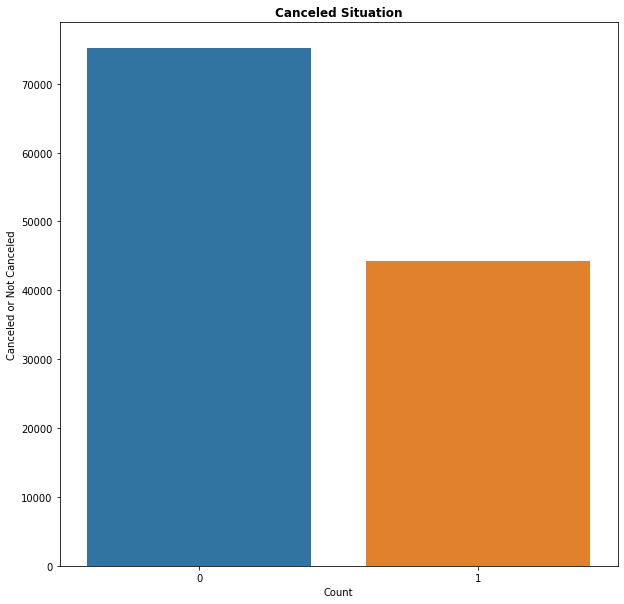

In [8]:
#canceled features
plt.figure(figsize=(10,10))
sns.countplot(data= df, x='is_canceled',  orient = 'v')
plt.title('Canceled Situation', weight='bold')
plt.xlabel('Count', fontsize=10) 
plt.ylabel('Canceled or Not Canceled', fontsize=10)

booking was canceled (1) or not canceled(0)

37% of booking was canceled, 63% of booking was not canceled

In [9]:
#convert monthto numerical

df['arrival_date_month'].replace({'January' : '1','February' : '2','March' : '3','April' : '4','May' : '5','June' : '6','July' : '7','August' : '8','September' : '9', 'October' : '10','November' : '11','December' : '12'}, inplace=True)

In [10]:
print(df['arrival_date_month'].head(10))

0    7
1    7
2    7
3    7
4    7
5    7
6    7
7    7
8    7
9    7
Name: arrival_date_month, dtype: object


Text(0, 0.5, 'Count')

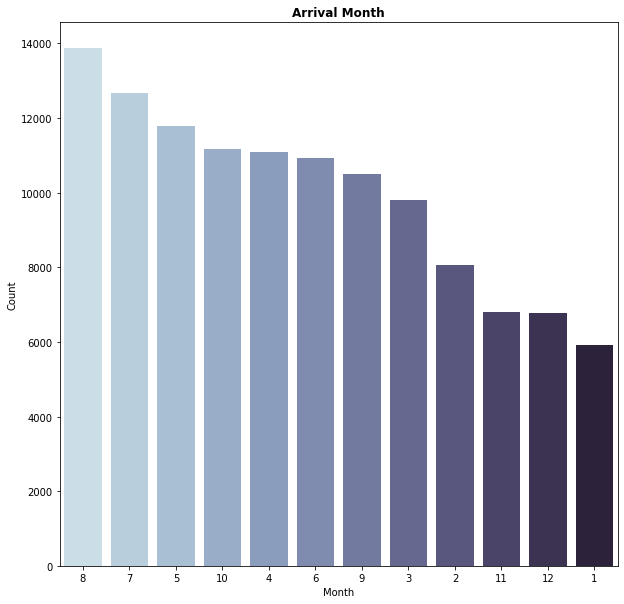

In [11]:
#arrival month features
plt.figure(figsize=(10,10))
sns.countplot(data = df, x='arrival_date_month',  order=df['arrival_date_month'].value_counts().index, palette='ch:s=.25,rot=-.25')
plt.title('Arrival Month', weight='bold')
plt.xlabel('Month', fontsize=10)

plt.ylabel('Count', fontsize=10)

Aug is the time have most guests

Jan is the fewer guests than Aug, equal half as Aug

In [12]:
pd.crosstab(index = df['stays_in_week_nights'],columns=df['stays_in_weekend_nights'], margins=True, margins_name = 'Total').iloc[:10]

stays_in_weekend_nights,0,1,2,3,4,5,6,7,8,9,10,12,13,14,16,18,19,Total
stays_in_week_nights,,,,,,,,,,,,,,,,,,
0,715,4569,2361,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7645
1,16451,7326,6533,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30310
2,17956,8979,6749,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33684
3,11564,6152,4542,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22258
4,4482,2412,2669,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9563
5,830,1188,8655,310,94,0,0,0,0,0,0,0,0,0,0,0,0,11077
6,0,0,851,301,347,0,0,0,0,0,0,0,0,0,0,0,0,1499
7,0,0,446,399,184,0,0,0,0,0,0,0,0,0,0,0,0,1029
8,0,0,393,131,132,0,0,0,0,0,0,0,0,0,0,0,0,656


there some missing values and have 715 values equal zero in both week nights and weekend nights

In [13]:
#combine children with babies to create all_childrens 
df['all_childrens'] = df['children'] + df['babies']
pd.crosstab(df['adults'], df['all_childrens'], margins=True, margins_name = 'Total').iloc[:10]


all_childrens,0.0,1.0,2.0,3.0,9.0,10.0,Total
adults,,,,,,,
0,180,4,205,14,0,0,403
1,22577,286,157,6,1,0,23027
2,81557,4658,3369,91,0,2,89677
3,5665,495,41,0,0,0,6201
4,59,3,0,0,0,0,62
5,2,0,0,0,0,0,2
6,1,0,0,0,0,0,1
10,1,0,0,0,0,0,1
20,2,0,0,0,0,0,2


there have 180 missing when values equal zero in both adults and all_childrens

Text(0, 0.5, 'Count')

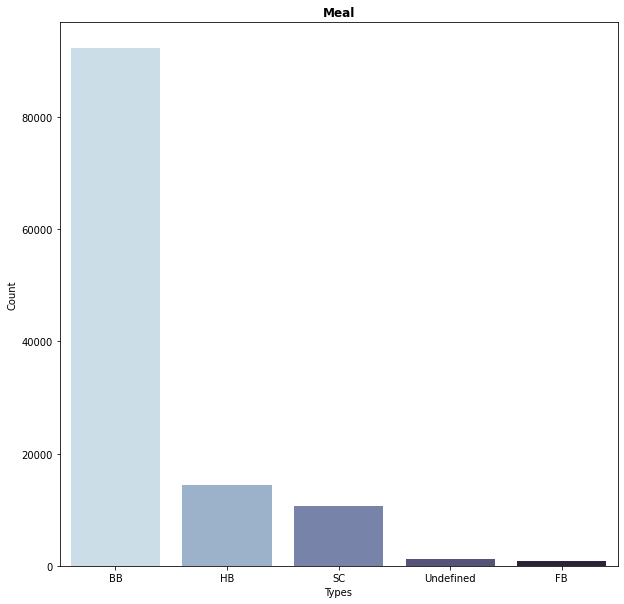

In [14]:
plt.figure(figsize=(10,10))
sns.countplot(data = df, x='meal',  order=df['meal'].value_counts().index, palette='ch:s=.25,rot=-.25')
plt.title('Meal', weight='bold')
plt.xlabel('Types', fontsize=10)

plt.ylabel('Count', fontsize=10)

meal is an important feature, we should focus on meal also

most of guests prefer to served Bed&Breakfast (about 80%)

In [15]:
#compare preference of guests in city and resort hotel
group_meal = df.groupby(['hotel','meal']).size().unstack(fill_value=0).transform(lambda x: x/x.sum())
group_meal.applymap('{:.2f}'.format)

meal,BB,FB,HB,SC,Undefined
hotel,,,,,
City Hotel,0.67,0.06,0.44,0.99,0.00
Resort Hotel,0.33,0.94,0.56,0.01,1.00


Text(0, 0.5, 'Count')

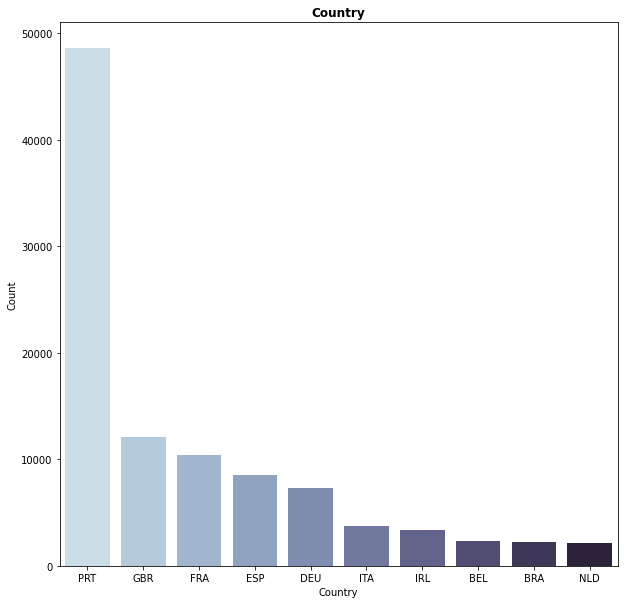

In [16]:
#country features
plt.figure(figsize=(10,10))
sns.countplot(data = df, x='country',  order=df['country'].value_counts().iloc[:10].index, palette='ch:s=.25,rot=-.25')
plt.title('Country', weight='bold')
plt.xlabel('Country', fontsize=10)

plt.ylabel('Count', fontsize=10)

we pick top 10 country cause there too many countries in data

as we see, Portugal is the most country with visitors

Text(0, 0.5, 'ADR')

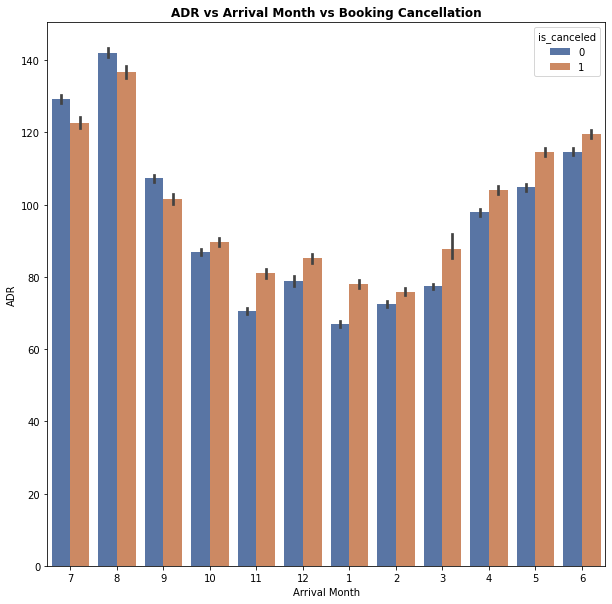

In [17]:
plt.figure(figsize=(10,10))
sns.barplot(data = df, x='arrival_date_month', y='adr', hue='is_canceled', dodge=True, palette= 'deep')
plt.title('ADR vs Arrival Month vs Booking Cancellation', weight='bold')
plt.xlabel('Arrival Month', fontsize=10)
plt.ylabel('ADR', fontsize=10)

Text(0, 0.5, 'Count')

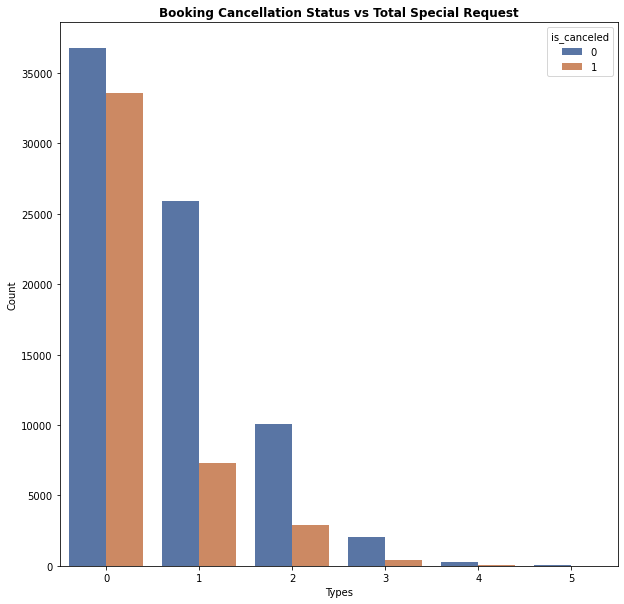

In [18]:
plt.figure(figsize=(10,10))
sns.countplot(data = df, x='total_of_special_requests', hue ='is_canceled', palette='deep')
plt.title('Booking Cancellation Status vs Total Special Request', weight='bold')
plt.xlabel('Types', fontsize=10)
plt.ylabel('Count', fontsize=10)

##Finding out and filling mising values

In [19]:
#find missing values
total = df.isnull().sum().sort_values(ascending=False)
missing_data = pd.concat([total], axis=1, keys=['Total'])
missing_data[missing_data.Total>0]

,Total
company,112593
agent,16340
country,488
all_childrens,4
children,4


In [20]:
# Fill missing numeric feature with 0
fill_with_zero=['company','agent','country','all_childrens','children']
for col in fill_with_zero:
  df[col] = df[col].fillna(0)

In [21]:
#recheck missing values
total = df.isnull().sum().sort_values(ascending=False)
missing_data = pd.concat([total], axis=1, keys=['Total'])
missing_data[missing_data.Total>0]

,Total


##Finish up data

In [22]:
# Change data type

df['agent']= df['agent'].astype(int)
df['country']= df['country'].astype(str)

In [23]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['hotel'] = labelencoder.fit_transform(df['hotel'])
df['arrival_date_month'] = labelencoder.fit_transform(df['arrival_date_month'])
df['meal'] = labelencoder.fit_transform(df['meal'])
df['country'] = labelencoder.fit_transform(df['country'])
df['market_segment']= labelencoder.fit_transform(df['market_segment'])
df['distribution_channel']=labelencoder.fit_transform(df['distribution_channel'])
df['is_repeated_guest'] = labelencoder.fit_transform(df['is_repeated_guest'])
df['reserved_room_type'] = labelencoder.fit_transform(df['reserved_room_type'])
df['assigned_room_type'] = labelencoder.fit_transform(df['assigned_room_type'])
df['deposit_type'] = labelencoder.fit_transform(df['deposit_type'])
df['agent'] = labelencoder.fit_transform(df['agent'])
df['customer_type'] = labelencoder.fit_transform(df['customer_type'])
df['reservation_status'] = labelencoder.fit_transform(df['reservation_status'])
df['stays_in_weekend_nights'] = labelencoder.fit_transform(df['stays_in_weekend_nights'])
df['stays_in_week_nights'] = labelencoder.fit_transform(df['stays_in_week_nights'])

In [24]:
# categorical data as new dataframe 

categorical = df[['hotel','is_canceled','arrival_date_month','meal',
                                     'country','market_segment','distribution_channel', 
                                     'is_repeated_guest', 'reserved_room_type',
                                     'assigned_room_type','deposit_type','agent',
                                     'customer_type','reservation_status', 
                                     'stays_in_weekend_nights','stays_in_week_nights']]
categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   hotel                    119390 non-null  int64
 1   is_canceled              119390 non-null  int64
 2   arrival_date_month       119390 non-null  int64
 3   meal                     119390 non-null  int64
 4   country                  119390 non-null  int64
 5   market_segment           119390 non-null  int64
 6   distribution_channel     119390 non-null  int64
 7   is_repeated_guest        119390 non-null  int64
 8   reserved_room_type       119390 non-null  int64
 9   assigned_room_type       119390 non-null  int64
 10  deposit_type             119390 non-null  int64
 11  agent                    119390 non-null  int64
 12  customer_type            119390 non-null  int64
 13  reservation_status       119390 non-null  int64
 14  stays_in_weekend_nights  119390 non-

In [25]:
#Create new dataframe for numerical data

numerical= df.drop(['hotel','is_canceled', 'arrival_date_month','meal',
                                       'country','market_segment','distribution_channel', 
                                       'is_repeated_guest', 'reserved_room_type', 
                                       'assigned_room_type','deposit_type','agent', 
                                       'customer_type','reservation_status',
                                       'stays_in_weekend_nights','stays_in_week_nights'], axis = 1)
numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   lead_time                       119390 non-null  int64  
 1   arrival_date_year               119390 non-null  int64  
 2   arrival_date_week_number        119390 non-null  int64  
 3   arrival_date_day_of_month       119390 non-null  int64  
 4   adults                          119390 non-null  int64  
 5   children                        119390 non-null  float64
 6   babies                          119390 non-null  int64  
 7   previous_cancellations          119390 non-null  int64  
 8   previous_bookings_not_canceled  119390 non-null  int64  
 9   booking_changes                 119390 non-null  int64  
 10  company                         119390 non-null  float64
 11  days_in_waiting_list            119390 non-null  int64  
 12  adr             

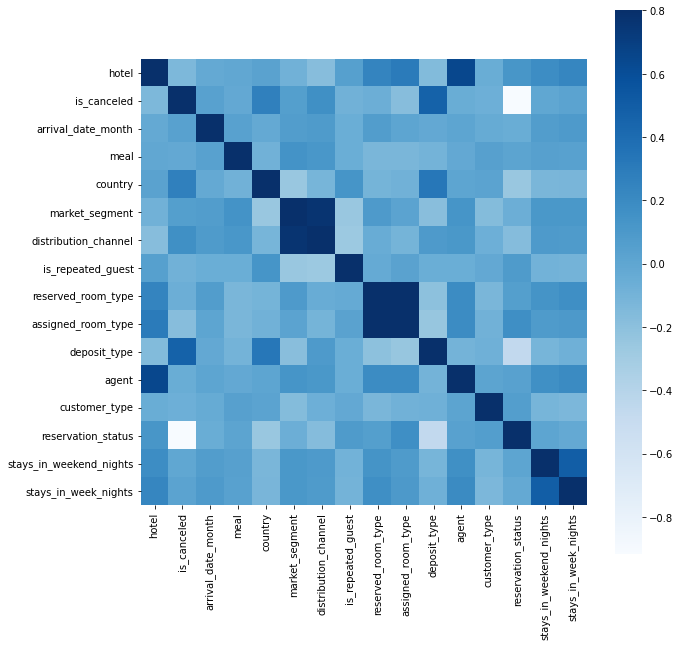

In [26]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(categorical.corr(), vmax=.8, square=True,xticklabels=True, yticklabels=True,cmap="Blues");

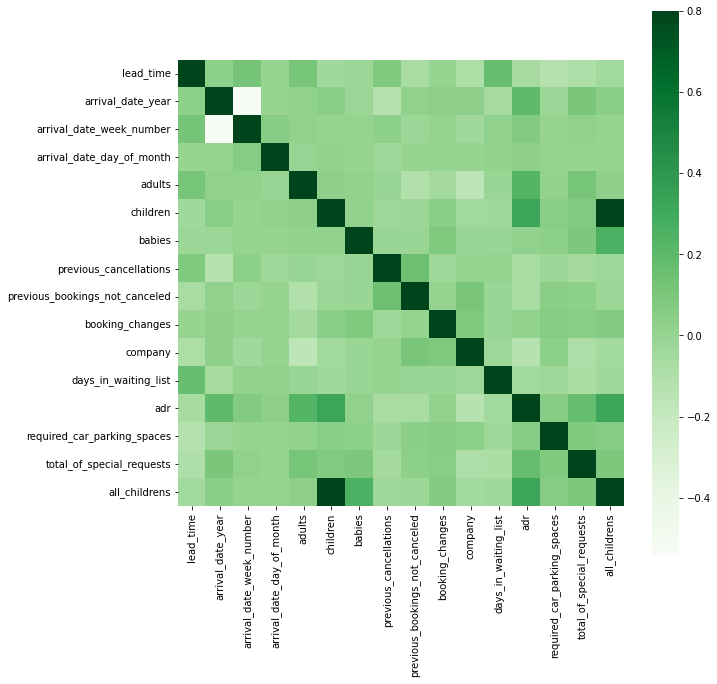

In [27]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(numerical.corr(method='pearson'),  vmax=.8, square=True,xticklabels=True, yticklabels=True,cmap="Greens" );

In [28]:
#Dropping unnecessary features

df = df.drop(['reservation_status', 'children', 'babies', 'reservation_status_date'], axis=1)

In [29]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,all_childrens
0,1,0,342,2015,9,27,1,0,0,2,...,3,0,0,0.0,0,2,0.0,0,0,0.0
1,1,0,737,2015,9,27,1,0,0,2,...,4,0,0,0.0,0,2,0.0,0,0,0.0
2,1,0,7,2015,9,27,1,0,1,1,...,0,0,0,0.0,0,2,75.0,0,0,0.0
3,1,0,13,2015,9,27,1,0,1,1,...,0,0,221,0.0,0,2,75.0,0,0,0.0
4,1,0,14,2015,9,27,1,0,2,2,...,0,0,174,0.0,0,2,98.0,0,1,0.0


In [30]:
#Check duplicated columns
df.columns.duplicated().sum()

0

##Data split

In [31]:
X = df.iloc[:,1]

In [32]:
#X = df.iloc[len(df['is_canceled']):, :]

y = df.iloc[:,1]
X = pd.concat([df.iloc[:,0],df.iloc[:,2:30]], axis=1)
X_test = pd.concat([df.iloc[:,0],df.iloc[:,2:30]], axis=1)
X.shape, df.shape, X_test.shape, y.shape



#X: Our trainning set.
#X_test: Use for final prediction.

((119390, 28), (119390, 29), (119390, 28), (119390,))

##Cross validation

We will use Kfold to evaluate our models. It helps avoid our model overfitting on training set.

In [33]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

In [34]:
#Define our error metric. Which is root mean squared error.

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, df['is_canceled'], scoring="neg_mean_squared_error", cv=kf,verbose=3,n_jobs=4))
    return (rmse)

##Model building

The list of models we will train our data on:

* Light gradient boosting
* XGBoost
* SVR
* Gradient Boosting Regressor




In [35]:
# light gradient boostting model
lightgbm=LGBMRegressor(feature_fraction=0.2, learning_rate=0.1,
              max_bin=100,min_data_in_bin=6, min_split_gain=0.0,
              min_sum_hessian_in_leaf=1, n_estimators=200,
              num_leaves=16, silent=True, subsample=0.7)
scores ={}
score = cv_rmse(lightgbm)
print("lightgbm: {:.6f} ({:.6f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    9.2s remaining:    4.0s


lightgbm: 0.324244 (0.001329)


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   10.9s finished


In [36]:
#extreme gradient boosting
xgb=XGBRegressor(objective ='reg:linear',criterion = 'giny', learning_rate = 0.01, max_depth = 5, n_estimators = 100, subsample = 1.0)
score = cv_rmse(xgb)
print("xgboost: {:.6f} ({:.6f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:  1.0min remaining:   26.9s


xgboost: 0.381470 (0.000883)


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  1.3min finished


In [37]:
# Decision Tree Model Building

dtc = DecisionTreeClassifier(criterion= 'gini', min_samples_split=8,
                                  min_samples_leaf = 4, max_features = 'auto')
score = cv_rmse(dtc)
print("dtc: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['dtc'] = (score.mean(), score.std())

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    1.2s remaining:    0.5s


dtc: 0.3873 (0.0036)


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.5s finished


In [38]:
# Random Forest Model Building

rf = RandomForestClassifier(min_samples_leaf = 6, min_samples_split=6,
                                  n_estimators = 100)
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:  1.0min remaining:   26.1s


rf: 0.3390 (0.0058)


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  1.3min finished


In [39]:
# Extra Treees Classsifier Model Building

etc = ExtraTreesClassifier(min_samples_leaf = 1, min_samples_split=2,
                                  n_estimators = 100)
score = cv_rmse(etc)
print("etc: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['etc'] = (score.mean(), score.std())

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:   59.8s remaining:   25.6s


etc: 0.3259 (0.0041)


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  1.2min finished


##Make prediction

In [40]:
df_score=pd.DataFrame.from_dict(scores,orient='index',columns=['rmse','std'])
df_score=df_score.rename_axis('model').reset_index()
df_score

,model,rmse,std
0,lgb,0.324244,0.001329
1,xgb,0.381470,0.000883
2,dtc,0.387287,0.003565
3,rf,0.338995,0.005755
4,etc,0.325881,0.004051


as we can see, light gradient boost have lowest error and we choose it to make prediction

In [41]:
#fit model

lightgbm.fit(X,df['is_canceled'])


LGBMRegressor(feature_fraction=0.2, max_bin=100, min_data_in_bin=6,
              min_sum_hessian_in_leaf=1, n_estimators=200, num_leaves=16,
              subsample=0.7)

In [42]:
#make prediction
predict_lightgbm = lightgbm.predict(X)


In [43]:
rmsle(y,predict_lightgbm)

0.3219232852771748

Our training  set have rmse of about 0.32

In [44]:
predict_lightgbm=lightgbm.predict(X_test)
predict_lightgbm=np.expm1(predict_lightgbm)

#Make predictions on the test set and use np.expm1 to cancel out the log transformation we did before.

In [47]:
rs=pd.DataFrame({'Canceled':predict_lightgbm})
rs[rs < 0] = 0
rs.index+=1461
rs.reset_index(inplace=True)

rs.to_csv('/content/drive/MyDrive/IU Sem1 2023/Data Analysis/Group 13_DA Project/result.csv',index=False)
rs

#make final result as csv

,index,Canceled
0,1461,0.314257
1,1462,0.314257
2,1463,0.000000
3,1464,0.024873
4,1465,0.167597
...,...,...
119385,120846,0.248877
119386,120847,0.443326
119387,120848,0.219753
119388,120849,0.376509
